# Assignment 3 - SED Fitting

## Bayesian Statistics

<div class="green">
This assignment is split into 3 sections, roughly corresponding to the contents of each of the 3 weeks in the Bayesian Statistics module. 

All assignments are presented as Jupyter notebooks. You will fork the repository to have your own access to all files. You can edit this notebook directly with your answers and push your changes to GitHub. 

### **The goal of this assignment is to use different MCMC and Bayesian inference techniques to fit SEDs to galaxy magnitudes**

<div class="green">

# STEP 0 - Prospector Inputs

Prospector has some in-built MCMC techniques that you will have used in Assignment 1 (Emcee or Dynesty). For this assignment you will not be using these in-built tools, instead you will use external libraries to code your own MCMC results and perform model comparison on them. We will however still use prospector for the model so lets prepare that here

### The model we are using is a very simple parametric model with 6 free parameters

* ### $z$ redshift
* ### $M_{\rm star}$ stellar mass
* ### $\log(z_{\rm sol})$ metallicity?
* ### dust V-band optical depth
* ### $t_{\rm age}$ The age of the host galaxy
* ### $\tau$


1. Activate the enviroment/kernel you used with prospector installed

2. Prepare the prospector model (if you like you can edit the below model, but you dont have to)

In [1]:
%%html
<style>
    .blue {
        background-color: #0074D9;
    }
    .green {
        background-color: #2ECC40;
    }
    .black {
        background-color: #000000;
    }
</style>

In [2]:
from prospect.models import SedModel, priors
from prospect.models.templates import TemplateLibrary
from prospect.sources import CSPSpecBasis
import time

model_params = TemplateLibrary["parametric_sfh"]

print(model_params)

# Let redshift vary
model_params["zred"]["isfree"] = True
model_params['zred']['init'] = 0.1
model_params['zred']['prior'] = priors.TopHat(mini=0,maxi=1)

# Build the model
prospector_model = SedModel(model_params)

sps = CSPSpecBasis(zcontinuous=1)


{'zred': {'N': 1, 'isfree': False, 'init': 0.1, 'units': 'redshift', 'prior': <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=4.0)}, 'mass': {'N': 1, 'isfree': True, 'init': 10000000000.0, 'units': 'Solar masses formed', 'prior': <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)}, 'logzsol': {'N': 1, 'isfree': True, 'init': -0.5, 'units': '$\\log (Z/Z_\\odot)$', 'prior': <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)}, 'dust2': {'N': 1, 'isfree': True, 'init': 0.6, 'units': 'optical depth at 5500AA', 'prior': <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)}, 'sfh': {'N': 1, 'isfree': False, 'init': 4, 'units': 'FSPS index'}, 'tage': {'N': 1, 'isfree': True, 'init': 1, 'units': 'Gyr', 'prior': <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)}, 'imf_type': {'N': 1, 'isfree': False, 'init': 2}, 'dust_type': {'N': 1, 'isfree': False, 'init': 0}, 'tau': {'N': 1, 'isfree': True, 'init': 1, 'units': 'Gyr^{-1}', 'prior'

In [3]:
import sedpy 
import prospect
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table

gal_id = 83613

with fits.open('../data/sw_input.fits') as f:
    df = Table(f[1].data).to_pandas()
    f.close()
print(df.iloc[gal_id])

with fits.open('../data/sw_output.fits') as f:
    df_out = Table(f[1].data).to_pandas()
    f.close()

print(df_out.iloc[gal_id])

id                          289679
ra                      210.258626
dec                       2.878469
redshift                  0.251958
PLATE                          531
MJD                          52028
FIBERID                        573
designation    J140102.01+025243.0
flux0_u                   0.000215
flux0_u_e                 0.000006
flux0_g                    0.00044
flux0_g_e                 0.000003
flux0_r                   0.000974
flux0_r_e                 0.000004
flux0_i                   0.001427
flux0_i_e                 0.000007
flux0_z                   0.001933
flux0_z_e                  0.00002
flux0_w1                  0.001984
flux0_w1_e                0.000051
flux0_w2                  0.001641
flux0_w2_e                0.000044
flux0_w3                  0.006153
flux0_w3_e                0.000204
flux0_w4                  0.014413
flux0_w4_e                0.001553
flux_u                    0.000242
flux_u_e                  0.000015
flux_g              

3. Load the data vector for a given galaxy (again you can change the <font color='red'> gaalxy <font color='black'> **galaxy** if you wish, maybe match one of your galaxies from assignment <font color='red'> 1 <font color='black'>)

In [4]:

with fits.open('../data/sw_input.fits') as f:
    df = Table(f[1].data).to_pandas()
    f.close()
    
def build_obs(gal_id):
    """Given an object, load in fluxes, convert them to nanomaggies, and create a dict used in Prospector."""

    inp = {}
    
    # Get dataframe row for the object
    row = df.iloc[gal_id]
    inp['redshift'] = row.redshift

    # Load the filter response curves from sedpy
    bands = [f'sdss_{filt}0' for filt in 'ugriz'] + [f'wise_w{n}' for n in range(1,5)]
    filters = sedpy.observate.load_filters(bands)
    inp['filters'] = filters
    
    # Fluxes and uncertainties - already in units of maggies
    cols = [f'flux_{filt}' for filt in 'ugriz'] + [f'flux_w{n}' for n in range(1,5)]
    fluxes = row[cols].values.astype(float) / 3631

    # Errors
    cols_err = [f'{col}_e' for col in cols]
    errs = row[cols_err].values.astype(float) / 3631

    # Anything with a value of 9.999 is null, so may need to mask those fluxes by editing phot_mask
    inp['maggies'] = fluxes
    inp['maggies_unc'] = errs
    inp['phot_mask'] = [True for val in fluxes] # Nothing masked here right now

    # This is an array of effective wavelengths for each of the filters.  
    # It is not necessary, but it can be useful for plotting so we store it here as a convenience
    inp["phot_wave"] = np.array([f.wave_effective for f in inp["filters"]])
    inp["wavelength"] = None
    
    # Populate other fields with default
    inp = prospect.utils.obsutils.fix_obs(inp)
    return inp

obs = build_obs(gal_id)

In [ ]:
obs

<div class="green">
4. Prepare a function that takes the 6 parameters as input, and outputs the predicted fluxes in maggies (once this is set up, you shouldn't have to use prospector directly again for this assignment)


In [5]:
#a random sample from the prospectors default priors (just to make sure the model runs)
random_input_values = np.array([model_params[k]['prior'].sample()[0] for k in model_params.keys() if model_params[k]['isfree']==True])
param_names = np.array([model_params[k]['name'] for k in model_params.keys() if model_params[k]['isfree']==True])
print('Parameters should enter the function in this order:')
print(param_names)

### THIS IS THE FUNCTION YOU CAN USE FOR ALL 
### YOUR MODEL PREDICTIONS FROM THIS POINT
def model(theta):
    return prospector_model.predict(theta, obs=obs, sps=sps)[1]



Parameters should enter the function in this order:
['zred' 'mass' 'logzsol' 'dust2' 'tage' 'tau']


<div class="green">
5. Prospector does some kind of caching under the hood such that the calls to the model that require uncached inputs take much longer than the cached ones

We can get around this by initially running the model at enough random parameter inputs to cover all of the possible cached file we will need (there is very likely a better way to do this)

Try to avoid calling the model with inputs outside of the range defined below

THIS LINE WILL TAKE A COUPLE MINUTES TO RUN


In [6]:
import scipy.stats
np.random.seed(1)

nsamples = 10

#prior boundaries
zred_min = 0.1
zred_max = 0.5
logmass_min = 11
logmass_max = 13
logzsol_min = -0.8
logzsol_max = 1.2
dust2_min = 0.2
dust2_max = 1
tage_min = 0.001
tage_max = 13.8
logtau_min = -0.2
logtau_max = np.log10(10)
#zred_min = 0.2
#zred_max = 0.5
#logmass_min = 10.5
#logmass_max = 13
#logzsol_min = -1.2
#logzsol_max = -0.4
#dust2_min = 0
#dust2_max = 2
#tage_min = 0.001
#tage_max = 13.8
#logtau_min = np.log10(0.1)
#logtau_max = np.log10(30)
theta_min = np.array([zred_min, logmass_min, logzsol_min, dust2_min, tage_min, logtau_min])
theta_max = np.array([zred_max, logmass_max, logzsol_max, dust2_max, tage_max, logtau_max])

#generate some random input parameter combos
lhc_sampling = scipy.stats.qmc.LatinHypercube(6)
input_params = theta_min + lhc_sampling.random(nsamples) * (theta_max-theta_min)
#un-log the mass and tau 
input_params[:,1] = 10.**input_params[:,1]
input_params[:,5] = 10.**input_params[:,5]

model_evals = np.zeros( (nsamples, obs['ndof']) )
for i in range(nsamples):
    start = time.time()
    model_evals[i] = model(input_params[i])
    finish = time.time()
    print(i, f'{finish-start}s')

0 28.643959760665894s
1 27.28236198425293s
2 14.272472143173218s
3 0.00710296630859375s
4 14.72804594039917s
5 0.0060999393463134766s
6 0.007887125015258789s
7 0.006518125534057617s
8 0.006232023239135742s
9 0.005148887634277344s


<div class="green">
    
# SECTION 1 - MCMC

<div class="green">
1. Pick (and install) your 2 favourite MCMC sampling method/implementation you learned about in the lectures (At least 1 of them should be a "nested" sampling method, as we will use the features of nested sampling later)

Some examples are shown below

#### Metropolis-Hastings and Gibbs sampling 
* The most famous sampling methods 
* Many people code their own versions
* There are many examples and packages online to do this (some examples we haven't tested [here](https://github.com/WenjieZ/easyMH) [here](https://pymcmcstat.readthedocs.io/en/latest/#pymcmcstat) [here](https://numeryst.com/gibbs-sampling-an-introduction-with-python-implementation/#Code_Example))

#### Ensemble
* More sophisticated samplers 
* Affine-invariant [EMCEE](https://emcee.readthedocs.io/en/stable/)
* KDE [Kombine](https://github.com/bfarr/kombine)

#### Nested sampling 
* [Multinest](https://github.com/rjw57/MultiNest)
* [Polychord](https://github.com/PolyChord/PolyChordLite)
* [Dynesty](https://dynesty.readthedocs.io/en/latest/index.html) (Has some really great documentation)

#### Other 
* [Nautilus](https://nautilus-sampler.readthedocs.io/en/stable/)


In [7]:
import dynesty
import nautilus
from dynesty import plotting as dyplot
import multiprocessing
import matplotlib.pyplot as plt
from nautilus import Prior
import emcee
import scipy
from nautilus import Sampler
import corner

In [125]:
### check they import here

<div class="green">

2. Fit your model to your data using your 2 chosen sampling techniques

* Choose flat top-hat priors for all parameters (you can look at your results from Assignment 1 to get some reasonable ranges) 
* Plot the resulting parameter constraints on top of each other. e.g. in a corner plot
* Do they agree with each other?

In [8]:
# Priors

zred_min = 0.1
zred_max = 0.5
logmass_min = 11
logmass_max = 13
logzsol_min = -0.8
logzsol_max = 1.2
dust2_min = 0.2
dust2_max = 1
tage_min = 0.001
tage_max = 13.8
logtau_min = -0.2
logtau_max = np.log10(10)
#zred_min = 0.2
#zred_max = 0.5
#logmass_min = 10.5
#logmass_max = 13
#logzsol_min = -1.2
#logzsol_max = -0.4
#dust2_min = 0
#dust2_max = 2
#tage_min = 0.001
#tage_max = 13.8
#logtau_min = np.log10(0.1)
#logtau_max = np.log10(30)
theta_min = np.array([zred_min, logmass_min, logzsol_min, dust2_min, tage_min, logtau_min])
theta_max = np.array([zred_max, logmass_max, logzsol_max, dust2_max, tage_max, logtau_max])

In [9]:
def ptform(u):
    bounds=np.array([theta_min,theta_max])
    vals=(bounds[1]-bounds[0])*u+bounds[0]
    return vals

input_params is the ptform(u) from the dynesty example.

model_evals is the model(theta) that goes in the log_likelihood.

obs is the input data.

In [10]:
def log_likelihood(p):
    sigma2=obs['maggies_unc']**2
    p[1] = 10.**p[1]
    p[5] = 10.**p[5]
    return -0.5 * np.sum((obs['maggies']- model(p)) ** 2 / sigma2 + np.log(sigma2))

In [35]:
#sampler = dynesty.NestedSampler(log_likelihood, ptform, 6,save_history=True,history_filename='A1835_dynesty_history.save')

In [42]:
#sampler.run_nested(maxiter=2000,checkpoint_file='dynesty.save')
#sresults = sampler.results

6003it [26:44,  3.74it/s, +500 | bound: 560 | nc: 1 | ncall: 438464 | eff(%):  1.485 | loglstar:   -inf < 150.622 <    inf | logz: 138.524 +/-  0.176 | dlogz:  0.002 >  0.509]


In [11]:
sampler= dynesty.NestedSampler.restore('dynesty.save')
#sresults=np.load('sresults_6000_A1835.npy',allow_pickle=True)
#sresults.item().keys()

In [155]:
#np.save('sresults_6000_A1835',sresults)
#np.save('sampler_6000_A1835',sampler)

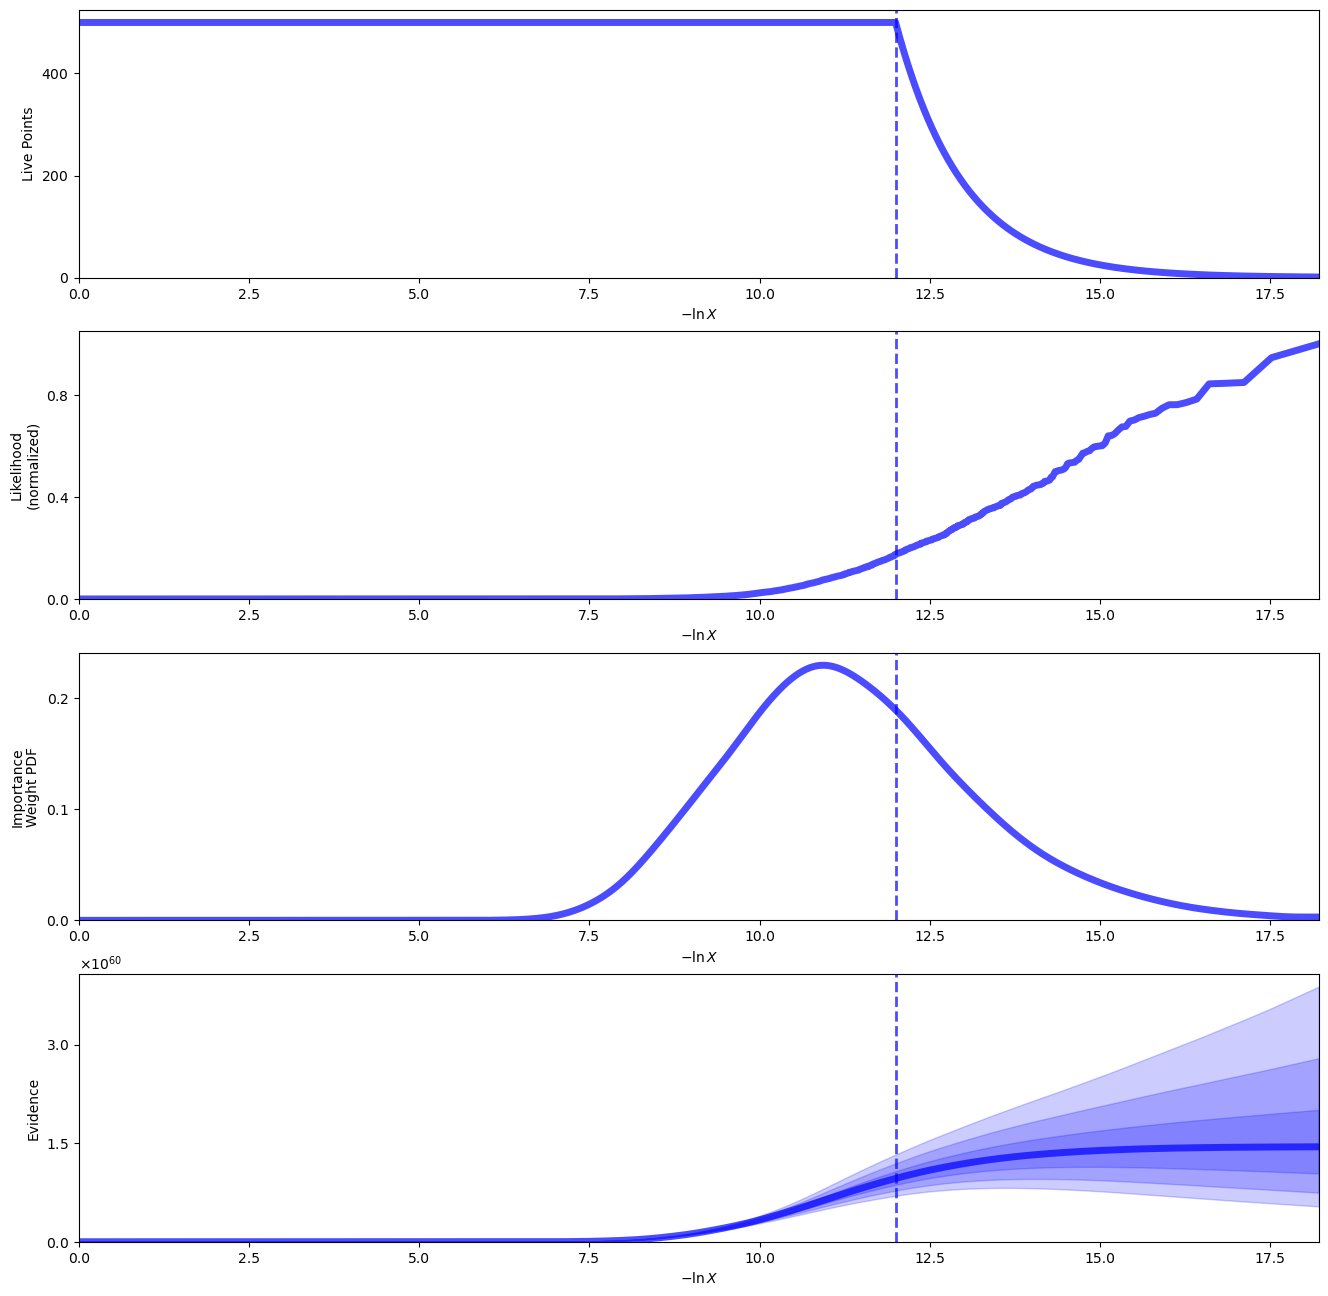

In [12]:
sresults = sampler.results
ndim=6
fig, axes = dyplot.runplot(sresults)  # summary (run) plot

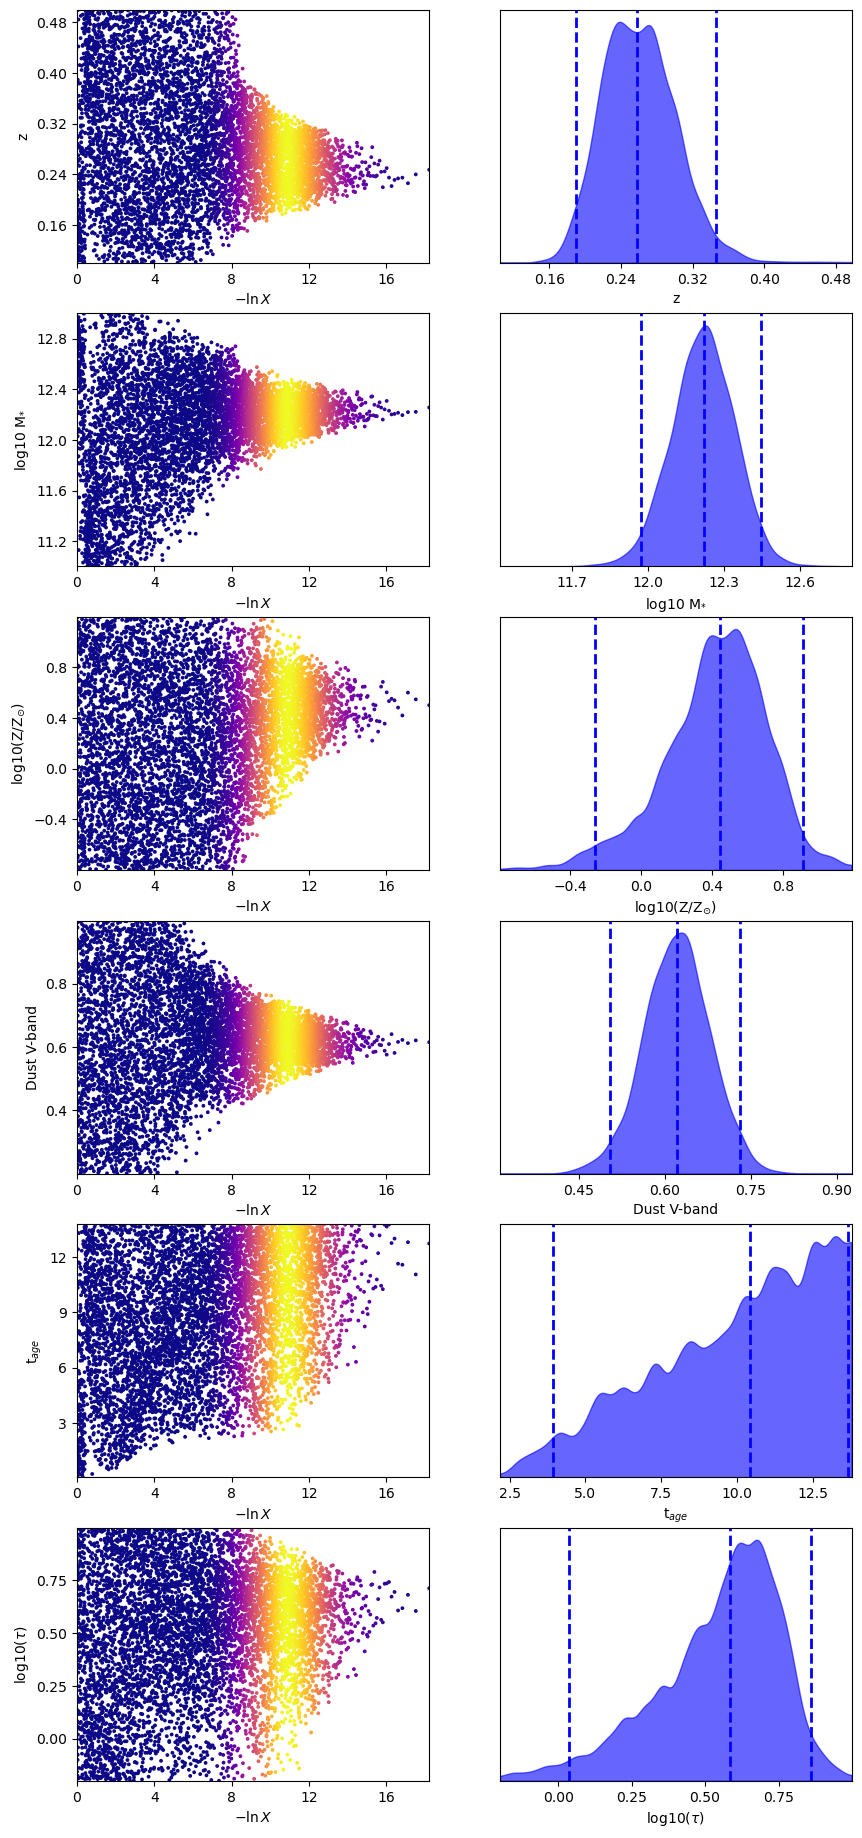

In [13]:
names=['z','log10 M$_{*}$','log10(Z/Z$_{\odot})$','Dust V-band','t$_{{age}}$','log10($\\tau$)']
fig, axes = dyplot.traceplot(sresults, labels=names,fig=plt.subplots(6,2,figsize=(10,23)))

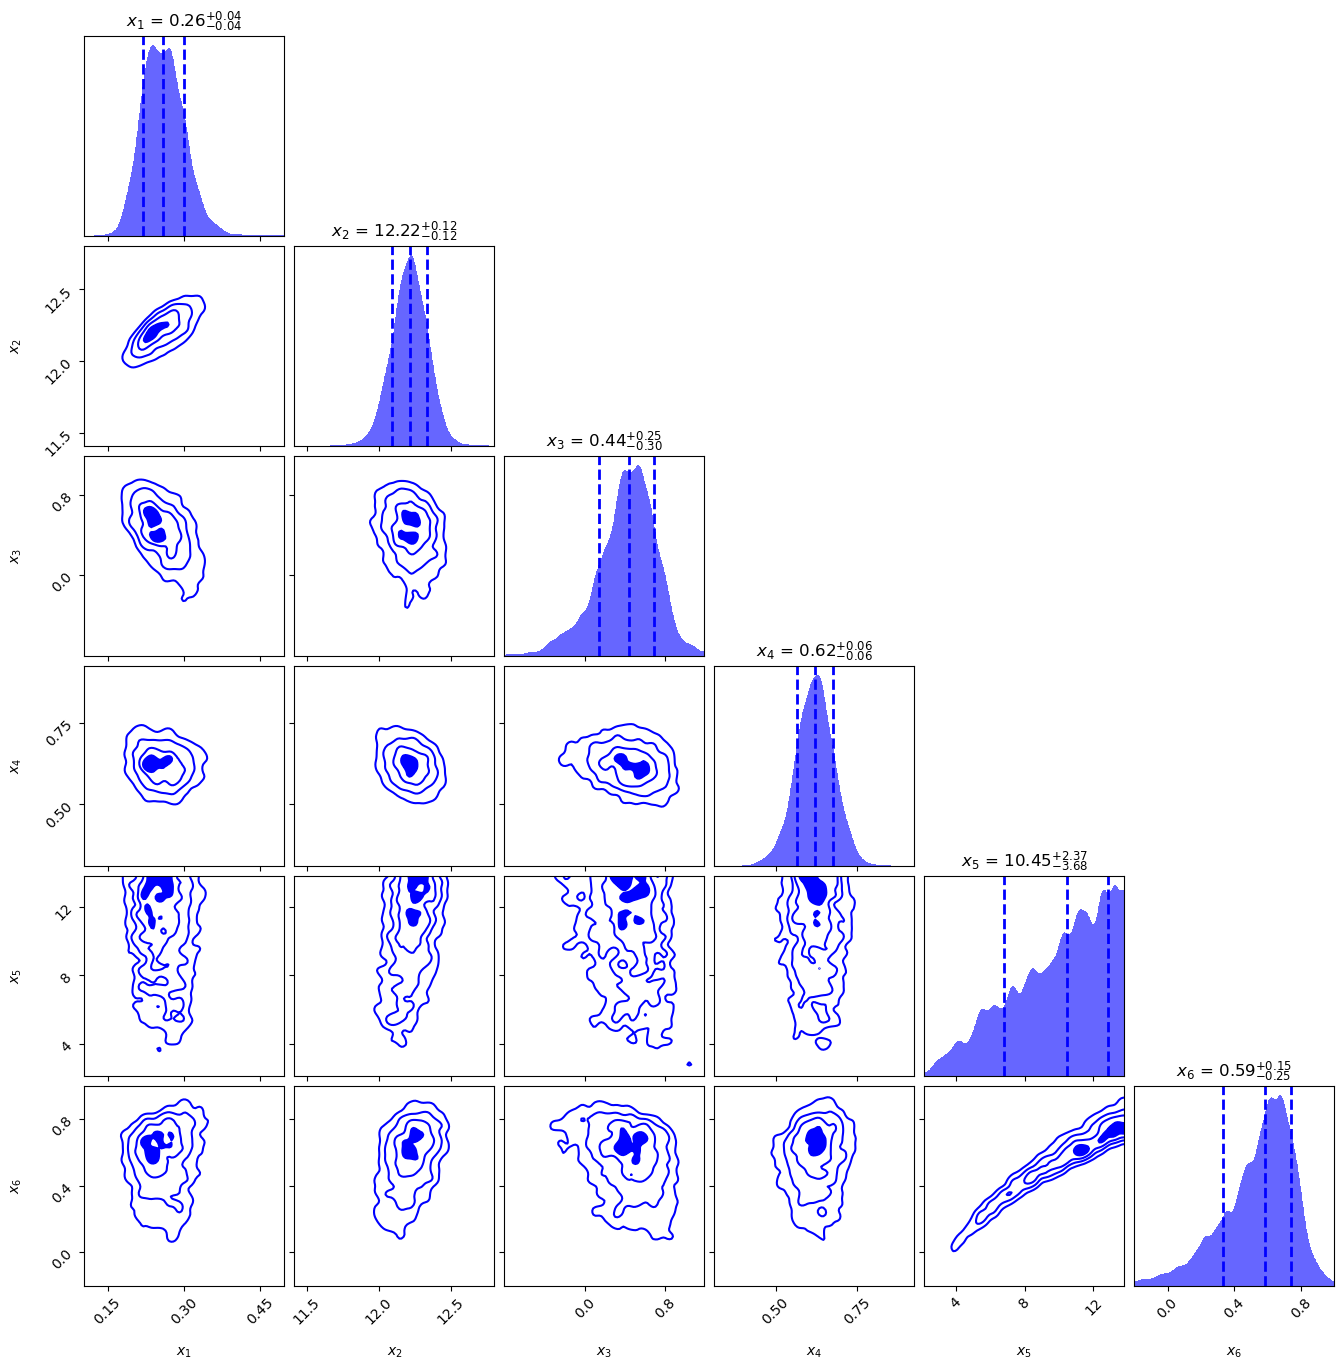

In [14]:
fg, ax = dyplot.cornerplot(sresults, color='blue', show_titles=True,
                           max_n_ticks=3, quantiles=[0.16, 0.5, 0.84], title_quantiles=(0.16,0.5,0.84),)

<font color='red'> 

### For some stupid reason, if I set the labels of the corner plots (x$_1$, x$_2$, ...) to the correct labels, it messes up the plot. So here are the corresponding labels:

### x$_1$ : Redshift

### x$_2$ : Log$_{10}$ M$_*$

### x$_3$ : Log$_{10}$(Z/Z$_{\odot})$

### x$_4$ : Dust V-band

### x$_5$ : t$_{{age}}$ (Gyr)

### x$_6$ : Log$_{10}$($\tau$)

## Nautilus

In [15]:
#These are the same priors as for the previous method

prior = Prior()

n_z_min,n_z_max=0.1,0.5
n_Mstar_min,n_Mstar_max=11,13
n_logz_min,n_logz_max=-0.8,1.2
n_vdust_min,n_vdust_max=0.2,1
n_tage_min,n_tage_max=0.001,13.6
n_tau_min,n_tau_max=-0.2,1

prior.add_parameter('z', dist=(n_z_min,n_z_max))
prior.add_parameter('log10M*', dist=(n_Mstar_min,n_Mstar_max))
prior.add_parameter('logz', dist=(n_logz_min,n_logz_max))
prior.add_parameter('vdust', dist=(n_vdust_min,n_vdust_max))
prior.add_parameter('tage', dist=(n_tage_min,n_tage_max))
prior.add_parameter('log10tau', dist=(n_tau_min,n_tau_max))

In [16]:
prior.keys

['z', 'log10M*', 'logz', 'vdust', 'tage', 'log10tau']

In [17]:
def n_log_likelihood(param_dict):
    p=np.array([param_dict['z'], param_dict['log10M*'], param_dict['logz'], param_dict['vdust'], param_dict['tage'], param_dict['log10tau']])
    sigma2=obs['maggies_unc']**2
    p[1] = 10.**p[1]
    p[5] = 10.**p[5]
    return -0.5 * np.sum((obs['maggies']- model(p)) ** 2 / sigma2 + np.log(sigma2))

In [18]:
sampler = Sampler(prior, n_log_likelihood, n_live=3000,filepath='Nautilus_A1835_result_v3.hdf5')
sampler.run(verbose=True,discard_exploration=True)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 24     | 1        | 4        | 92100    | N/A    | 10020 | +138.55  


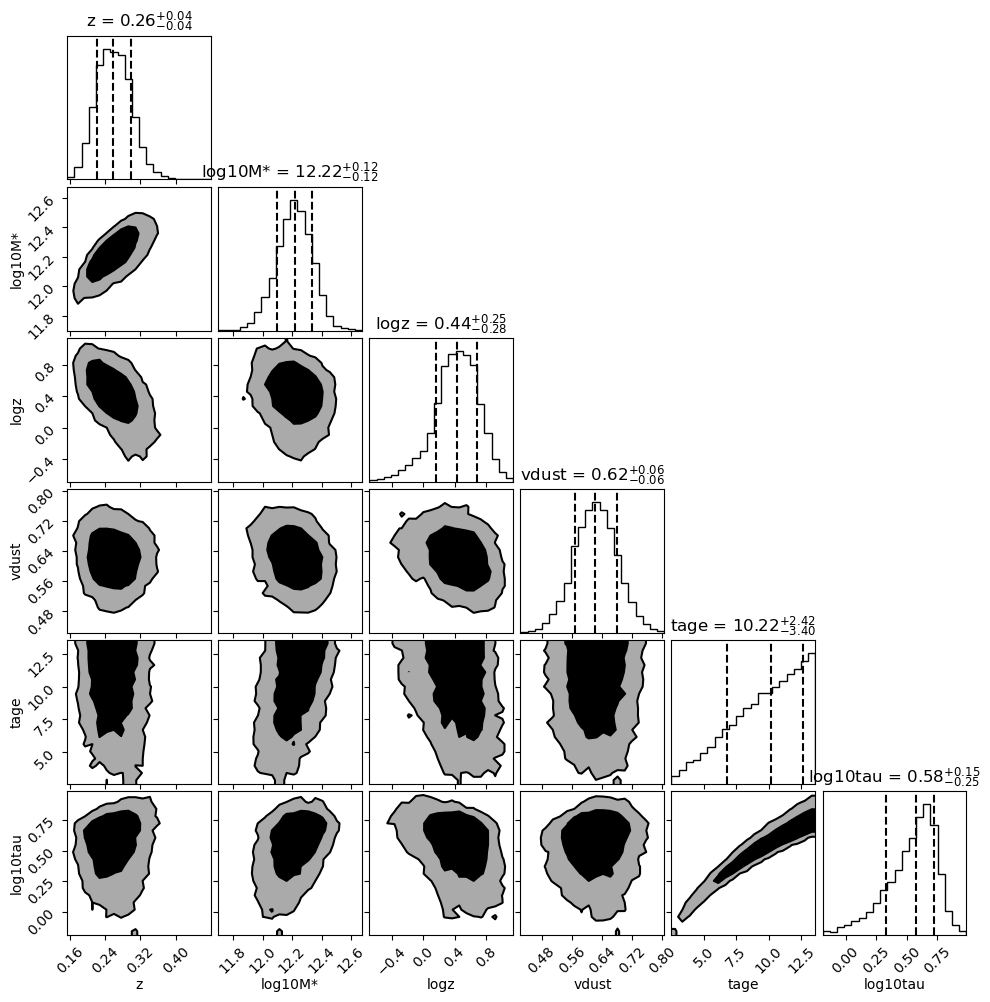

In [19]:
#points, log_w, log_l = sampler.posterior()
points,log_w,log_l=np.load('nautilus_points_A1835_v3.npy',allow_pickle=True),np.load('nautilus_log_w_A1835_v3.npy',allow_pickle=True),np.load('nautilus_log_l_A1835_v3.npy',allow_pickle=True)
ndim = points.shape[1]
fig, axes = plt.subplots(ndim, ndim, figsize=(10,10))
corner.corner(points, weights=np.exp(log_w), bins=20, labels=prior.keys,
              plot_datapoints=False, plot_density=False,range=np.ones(ndim) * 0.999,
              fill_contours=True, levels=(0.68, 0.95), quantiles=[0.16, 0.5, 0.84],fig=fig,show_titles=True)
plt.show()

In [126]:
#np.save('nautilus_log_l_A1835_v3',log_l)
#np.save('nautilus_points_A1835_v3',points)
#np.save('nautilus_log_w_A1835_v3',log_w)

In [327]:
#trial=np.load('sampler_nautilus_A1835.npy',allow_pickle=True)

In [20]:
def get_quantiles(x,weights):
    all_med=[]
    all_low=[]
    all_high=[]
    for i in range(len(x.T)):
        med=corner.core.quantile(x[:,i],0.5,weights=weights)[0]
        low=med-corner.core.quantile(x[:,i],0.16,weights=weights)[0]
        high=corner.core.quantile(x[:,i],0.84,weights=weights)[0]-med
        all_med.append(med)
        all_low.append(low)
        all_high.append(high)
    return np.array(all_med),np.array(all_low),np.array(all_high)
        

In [21]:
samples_dynesty = sresults['samples']
weights_dynesty = sresults.importance_weights()

q_dynesty=get_quantiles(samples_dynesty,weights_dynesty)
q_nautilus=get_quantiles(points,np.exp(log_w))

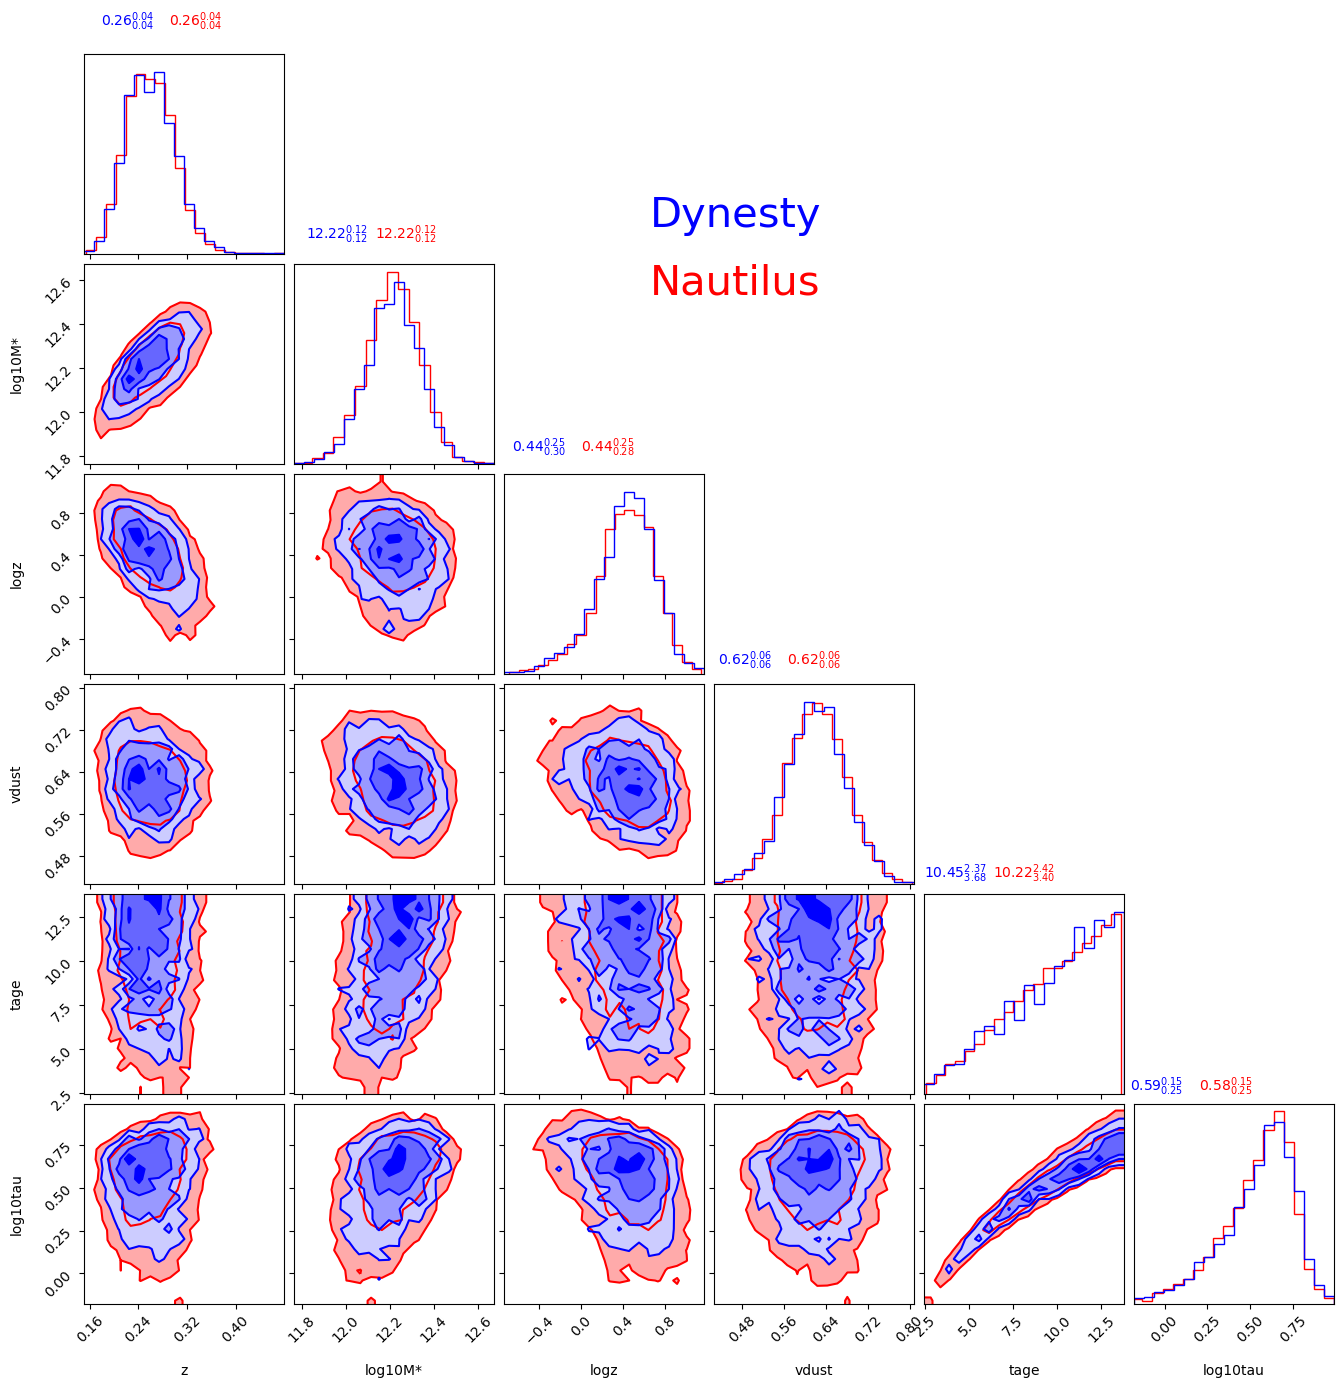

In [22]:

fig= corner.corner(points, weights=np.exp(log_w), bins=20, labels=prior.keys,
              plot_datapoints=False, plot_density=False,
              fill_contours=True, levels=(0.68, 0.95),
              range=np.ones(ndim) * 0.999,color='red')
corner.corner(samples_dynesty, weights=weights_dynesty, bins=20, labels=prior.keys,
              plot_datapoints=False, plot_density=False,
              fill_contours=True,
              range=np.ones(ndim) * 0.999,color='blue',alpha=0.5,fig=fig)
plt.text(-3,0.8,'Dynesty',color='blue',fontsize=30)
plt.text(-3,0.75,'Nautilus',color='red',fontsize=30)
for i in range(len(q_dynesty[0])):
    num=len(q_dynesty[0])
    plt.text(-num+i*1.2-0.2,0.95-0.95/num*i,'{:.2f}'.format(q_dynesty[0][i])+r'$_{'+'{:.2f}'.format(q_dynesty[1][i])+r'}^{'+'{:.2f}'.format(q_dynesty[2][i])+r'}$',color='blue')
    plt.text(-num+i*1.2+0.2,0.95-0.95/num*i,'{:.2f}'.format(q_nautilus[0][i])+r'$_{'+'{:.2f}'.format(q_nautilus[1][i])+r'}^{'+'{:.2f}'.format(q_nautilus[2][i])+r'}$',color='red')
plt.show()

<font color='red'> 

### The results of the 2 methods agree with each other. All parameters are consistent within less than 1 $\sigma$ for the different fitting methods, even for the host galaxy's age whose value is not well constrained by either model.

<div class="green">

3. Did either of your sampling methods have a burn-in? if so make a plot showing the burn-in and justify how much burn-in to remove. If not, explain why there is no burn-in in your methods

<font color='red'> 

### Dynesty does not have a burn-in. Nested sampling does not require a burn-in because it uses the prior to integrate over the posterior. Initial points get a very low weight (likelihood) so they don't really matter.

### Nautilus uses something called an exploration phase, which could be kind of seen as a burn-in phase but it's not really the same. Nautilus does not really require a burn-in for the same reason as for Dynesty, initial points have a very low weight and will not significantly matter. However, there can be a basically negligeable bias in the resulting posterior and evidence values when the points obtained from the exploration phase are kept. It's preferable to discard them although even if you don't, it shouldn't really impact your results. Basically, Nautilus is being kind of paranoid but it's fine.

Note: tage and $\tau$ are positively correlated. tage is not constrained by our model.

<div class="green">

# SECTION 2 - Model Comparison

<div class="green">

1. Use the nested sampling technique you chose in Section 1 to compute the Baysian Evidence of your model fit

<font color='red'> 

### Both methods give me the evidence so I will get both.

In [23]:
# Nautilus
logz_nautilus=sampler.log_z
evidence_nautilus=np.exp(logz_nautilus)
print('{:.2e}'.format(evidence_nautilus))

1.48e+60


In [24]:
# Dynesty

logz_dynesty=sresults['logz']
#logzerr_dynesty=sresults['logzerr']
evidence_dynesty=np.exp(logz_dynesty[-1])
print('{:.2e}'.format(evidence_dynesty))

1.45e+60


<div class="green">

2. Change the model in some-way and re-run your nested sampling chain (e.g. add/remove a new parameter, or dramatically change the prior on a parameter)

<font color='red'> 

### Re-running with new model where the redshift is fixed.

In [25]:
model_params_v2 = TemplateLibrary["parametric_sfh"]


# Let redshift vary
model_params_v2["zred"]["isfree"] = False
model_params_v2['zred']['init'] = obs['redshift']
#model_params_agn['zred']['prior'] = priors.TopHat(mini=0,maxi=1)

prospector_model_v2 = SedModel(model_params_v2)

sps_v2 = CSPSpecBasis(zcontinuous=1)

In [26]:
def model_v2(theta):
    return prospector_model_v2.predict(theta, obs=obs, sps=sps_v2)[1]

In [27]:
logmass_min_v2 = logmass_min
logmass_max_v2 = logmass_max
logzsol_min_v2 = logzsol_min
logzsol_max_v2 = logzsol_max
dust2_min_v2 = dust2_min
dust2_max_v2 = dust2_max
tage_min_v2 = tage_min
tage_max_v2 = tage_max
logtau_min_v2 = logtau_min
logtau_max_v2 = logtau_max
theta_min_v2 = np.array([logmass_min_v2, logzsol_min_v2, dust2_min_v2, tage_min_v2, logtau_min_v2])
theta_max_v2 = np.array([logmass_max_v2, logzsol_max_v2, dust2_max_v2, tage_max_v2, logtau_max_v2])

In [28]:
lhc_sampling_v2 = scipy.stats.qmc.LatinHypercube(5)
input_params_v2 = theta_min_v2 + lhc_sampling_v2.random(nsamples) * (theta_max_v2-theta_min_v2)
#un-log the mass and tau 
input_params_v2[:,0] = 10.**input_params_v2[:,0]
input_params_v2[:,4] = 10.**input_params_v2[:,4]

model_evals_v2 = np.zeros( (nsamples, obs['ndof']) )
for i in range(nsamples):
    start = time.time()
    model_evals_v2[i] = model_v2(input_params_v2[i])
    finish = time.time()
    print(i, f'{finish-start}s')

0 28.917704105377197s
1 27.143906116485596s
2 14.346004009246826s
3 0.005913972854614258s
4 0.005889892578125s
5 0.006165981292724609s
6 14.317161083221436s
7 0.005305051803588867s
8 0.0054967403411865234s
9 0.005368947982788086s


In [29]:
def log_likelihood_v2(p):
    sigma2=obs['maggies_unc']**2
    p[0] = 10.**p[0]
    p[4] = 10.**p[4]
    return -0.5 * np.sum((obs['maggies']- model_v2(p)) ** 2 / sigma2 + np.log(sigma2))

In [30]:
def ptform_v2(u):
    bounds=np.array([theta_min_v2,theta_max_v2])
    vals=(bounds[1]-bounds[0])*u+bounds[0]
    return vals

In [156]:
#sampler_v2 = dynesty.NestedSampler(log_likelihood_v2, ptform_v2, 5)

In [164]:
#sampler_v2.run_nested(maxiter=2000,checkpoint_file='dynesty_v2.save')
#results_v2 = sampler_v2.results

5575it [03:38, 25.57it/s, +500 | bound: 120 | nc: 1 | ncall: 107068 | eff(%):  5.701 | loglstar:   -inf < 150.584 <    inf | logz: 140.150 +/-  0.149 | dlogz:  0.001 >  0.509]


In [31]:
sampler_v2= dynesty.NestedSampler.restore('dynesty_v2.save')
results_v2=sampler_v2.results

In [32]:
loglike=results_v2['logl']
samples=results_v2['samples']
best=np.where(loglike==np.max(loglike))
bestfit_params_v2=samples[best]

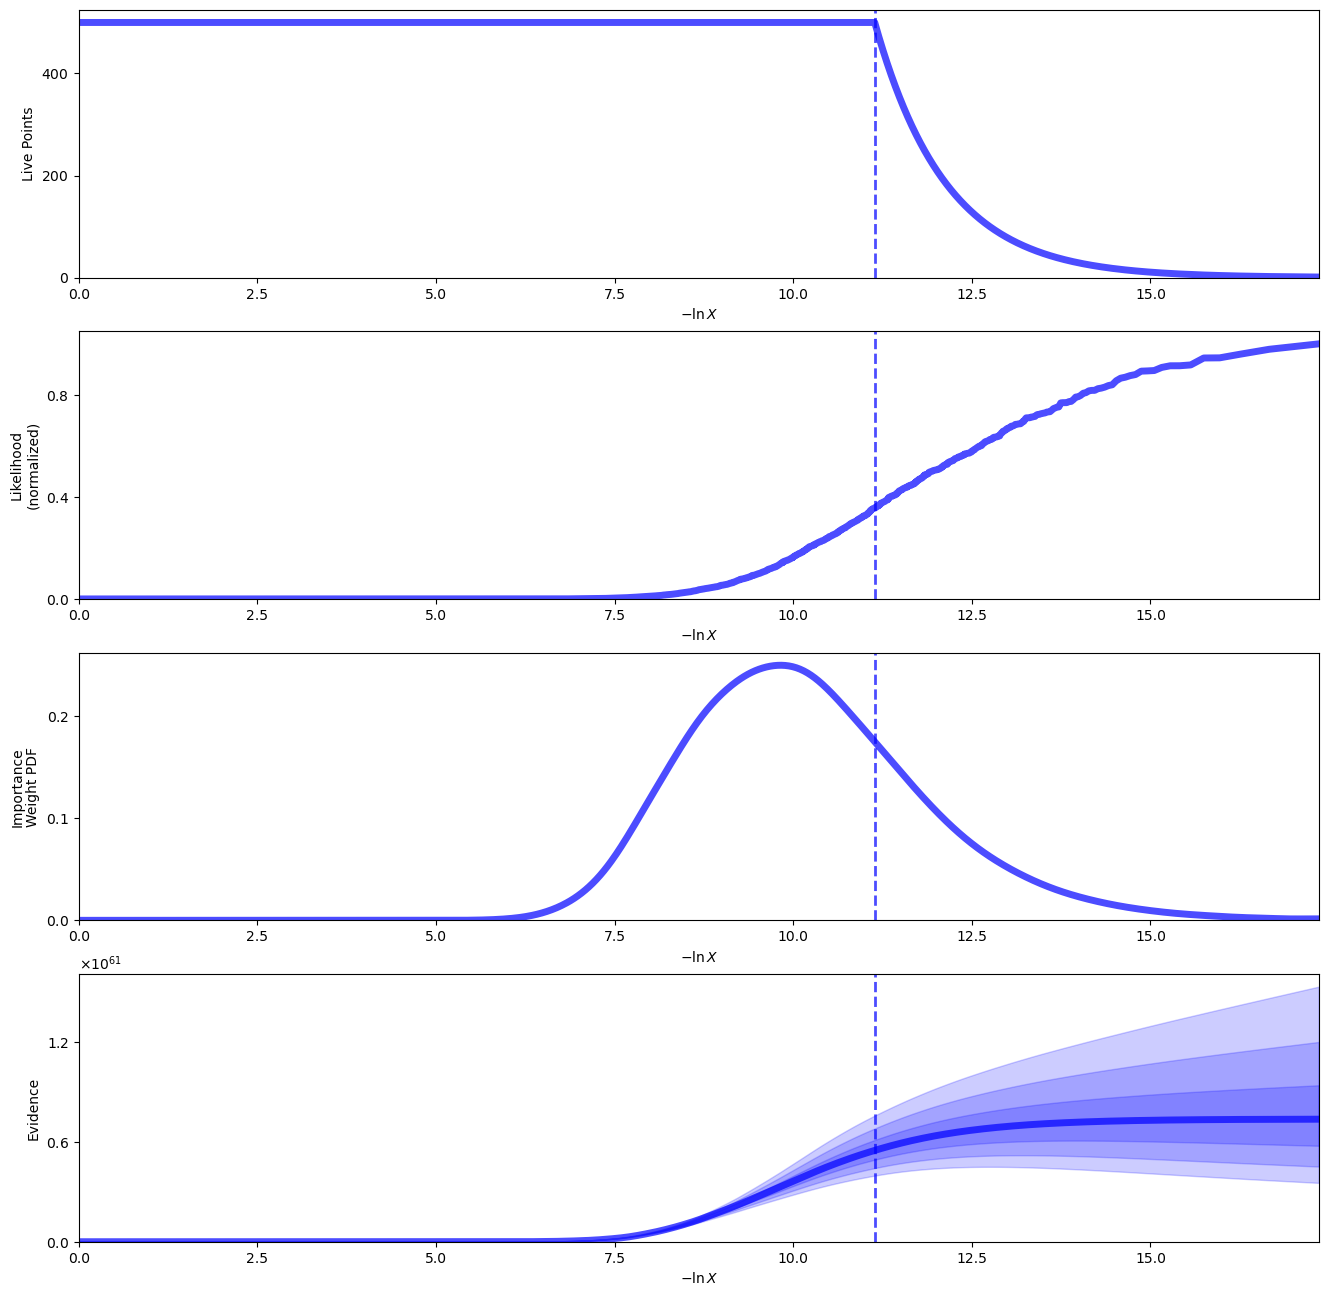

In [33]:
results_v2 = sampler_v2.results
ndim=5
fig, axes = dyplot.runplot(results_v2)

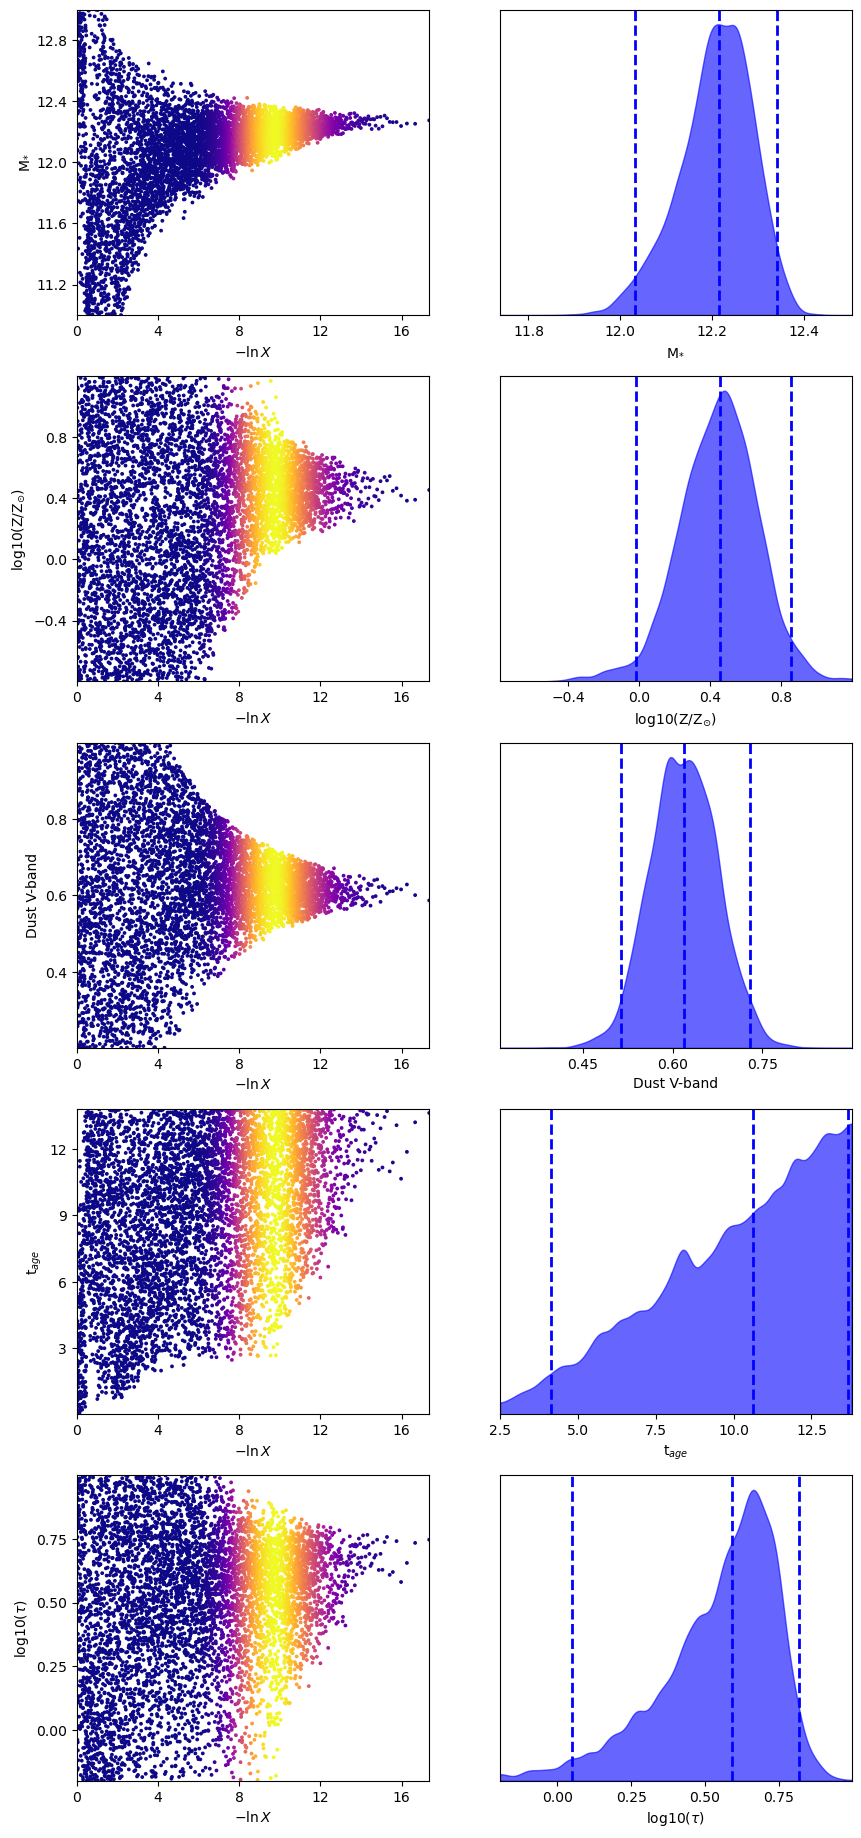

In [34]:
names_v2=['M$_{*}$','log10(Z/Z$_{\odot})$','Dust V-band','t$_{{age}}$','log10($\\tau$)']
fig, axes = dyplot.traceplot(results_v2, labels=names_v2,fig=plt.subplots(5,2,figsize=(10,23)))

Text(0.5, 0.98, 'Dynesty fixed redshift')

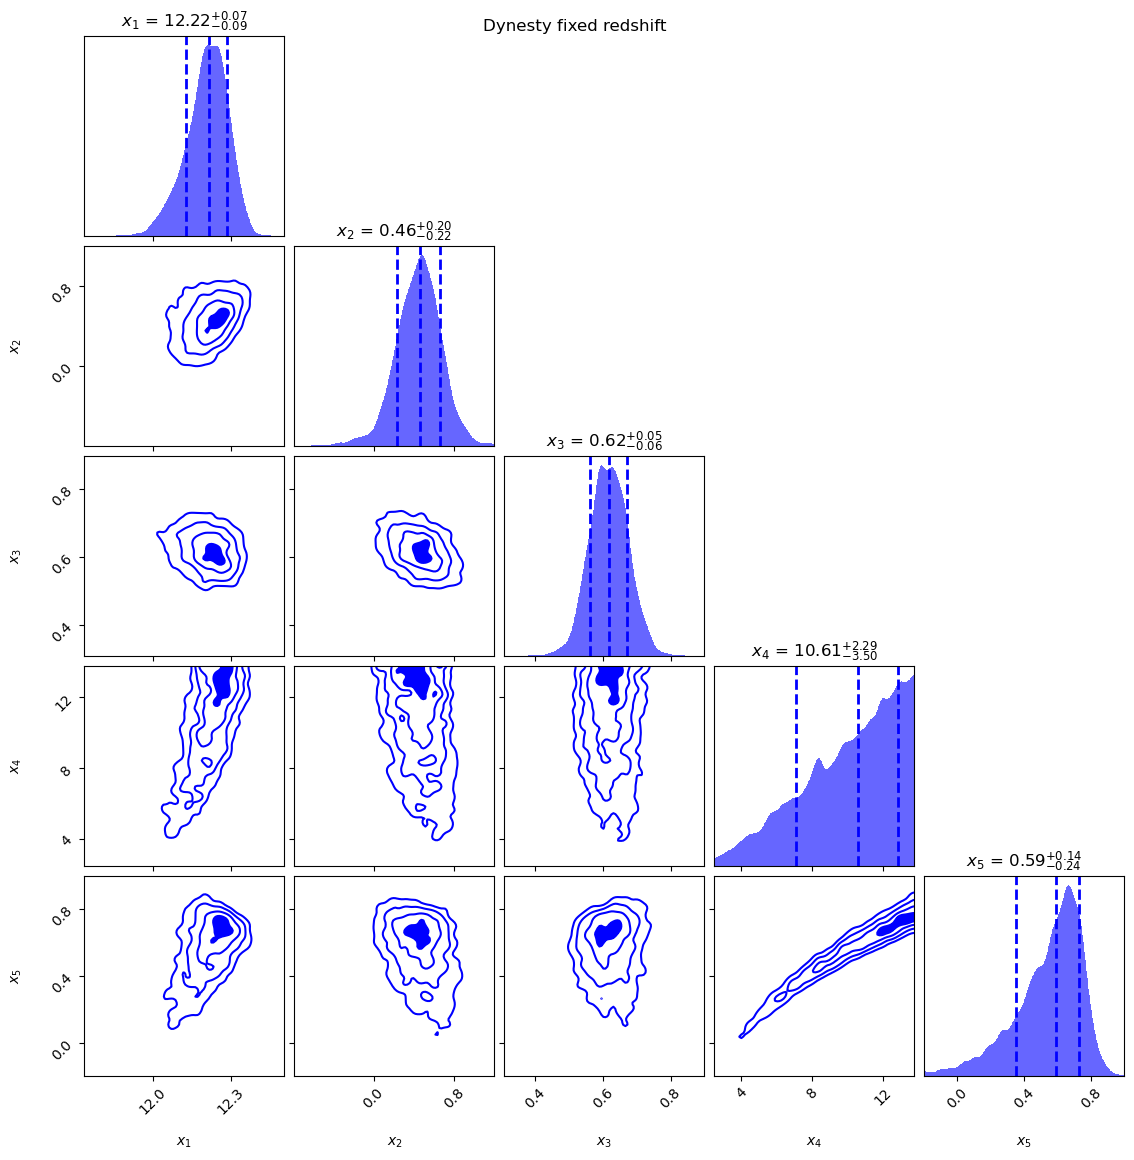

In [35]:
fg, ax = dyplot.cornerplot(results_v2, color='blue', show_titles=True,
                           max_n_ticks=3, quantiles=[0.16, 0.5, 0.84], title_quantiles=(0.16,0.5,0.84))
plt.suptitle('Dynesty fixed redshift')

<font color='red'> 

### For some stupid reason, if I set the labels of the corner plots (x$_1$, x$_2$, ...) to the correct labels, it messes up the plot. So here are the corresponding labels:

### x$_1$ : Log$_{10}$ M$_*$

### x$_2$ : Log$_{10}$(Z/Z$_{\odot})$

### x$_3$ : Dust V-band

### x$_4$ : t$_{{age}}$ (Gyr)

### x$_5$ : Log$_{10}$($\tau$)

In [36]:
#These are the same priors as for the previous method

prior_v2 = Prior()

n_Mstar_min_v2,n_Mstar_max_v2=11,13
n_logz_min_v2,n_logz_max_v2=-0.8,1.2
n_vdust_min_v2,n_vdust_max_v2=0.2,1
n_tage_min_v2,n_tage_max_v2=0.001,13.6
n_tau_min_v2,n_tau_max_v2=-0.2,1

prior_v2.add_parameter('log10M*', dist=(n_Mstar_min_v2,n_Mstar_max_v2))
prior_v2.add_parameter('logz', dist=(n_logz_min_v2,n_logz_max_v2))
prior_v2.add_parameter('vdust', dist=(n_vdust_min_v2,n_vdust_max_v2))
prior_v2.add_parameter('tage', dist=(n_tage_min_v2,n_tage_max_v2))
prior_v2.add_parameter('log10tau', dist=(n_tau_min_v2,n_tau_max_v2))

In [37]:
def n_log_likelihood_v2(param_dict):
    p=np.array([obs['redshift'], param_dict['log10M*'], param_dict['logz'], param_dict['vdust'], param_dict['tage'], param_dict['log10tau']])
    sigma2=obs['maggies_unc']**2
    p[1] = 10.**p[1]
    p[5] = 10.**p[5]
    return -0.5 * np.sum((obs['maggies']- model(p)) ** 2 / sigma2 + np.log(sigma2))

In [38]:
n_sampler_v2 = Sampler(prior_v2, n_log_likelihood_v2, n_live=3000,filepath='Nautilus_A1835_result_fixedz.hdf5')
n_sampler_v2.run(verbose=True,discard_exploration=True)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 22     | 1        | 4        | 85100    | N/A    | 10092 | +139.89  


In [209]:
#points_v2, log_w_v2, log_l_v2 = n_sampler_v2.posterior()
#np.save('nautilus_log_l_A1835_Q2',log_l_v2)
#np.save('nautilus_points_A1835_Q2',points_v2)
#np.save('nautilus_log_w_A1835_Q2',log_w_v2)

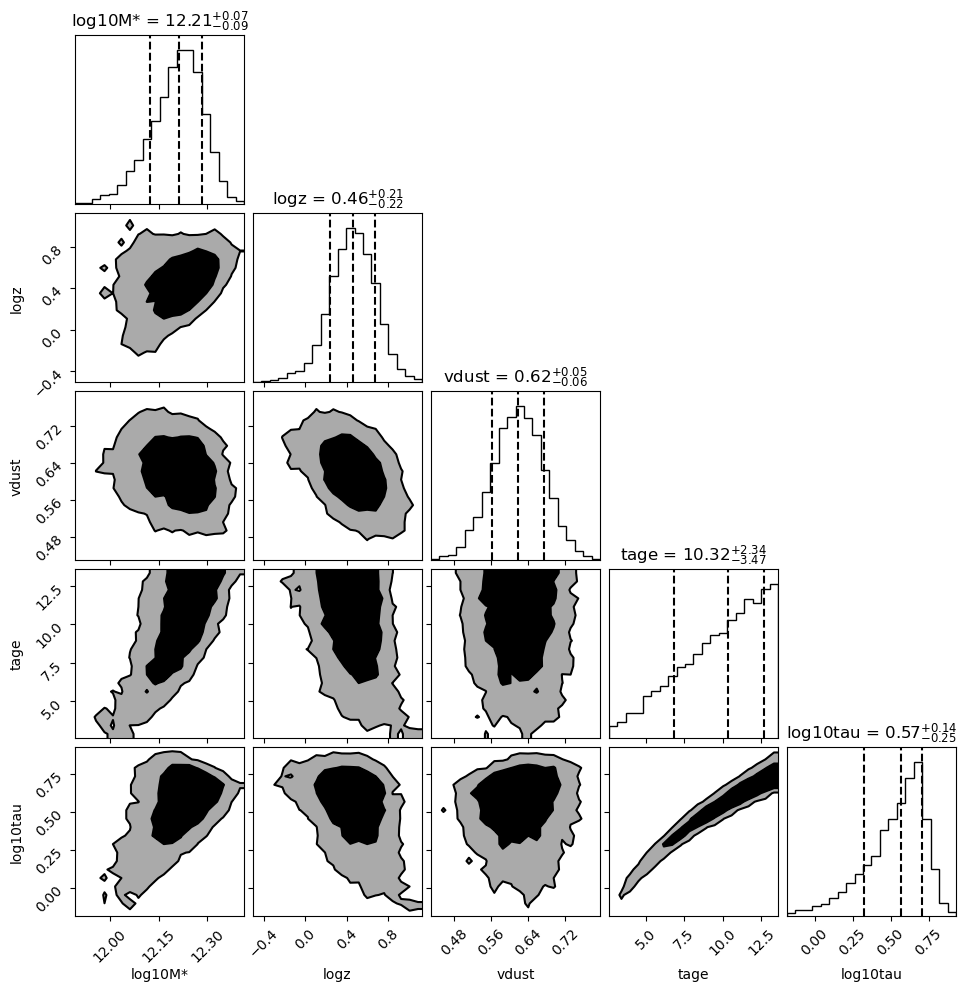

In [39]:
points_v2,log_w_v2,log_l_v2=np.load('nautilus_points_A1835_Q2.npy',allow_pickle=True),np.load('nautilus_log_w_A1835_Q2.npy',allow_pickle=True),np.load('nautilus_log_l_A1835_Q2.npy',allow_pickle=True)
ndim = points_v2.shape[1]
fig, axes = plt.subplots(ndim, ndim, figsize=(10,10))
corner.corner(points_v2, weights=np.exp(log_w_v2), bins=20, labels=prior_v2.keys,
              plot_datapoints=False, plot_density=False,range=np.ones(ndim) * 0.999,
              fill_contours=True, levels=(0.68, 0.95), quantiles=[0.16, 0.5, 0.84],fig=fig,show_titles=True)
plt.show()

In [40]:
samples_dynesty_v2 = results_v2['samples']
weights_dynesty_v2 = results_v2.importance_weights()

q_dynesty_v2=get_quantiles(samples_dynesty_v2,weights_dynesty_v2)
q_nautilus_v2=get_quantiles(points_v2,np.exp(log_w_v2))

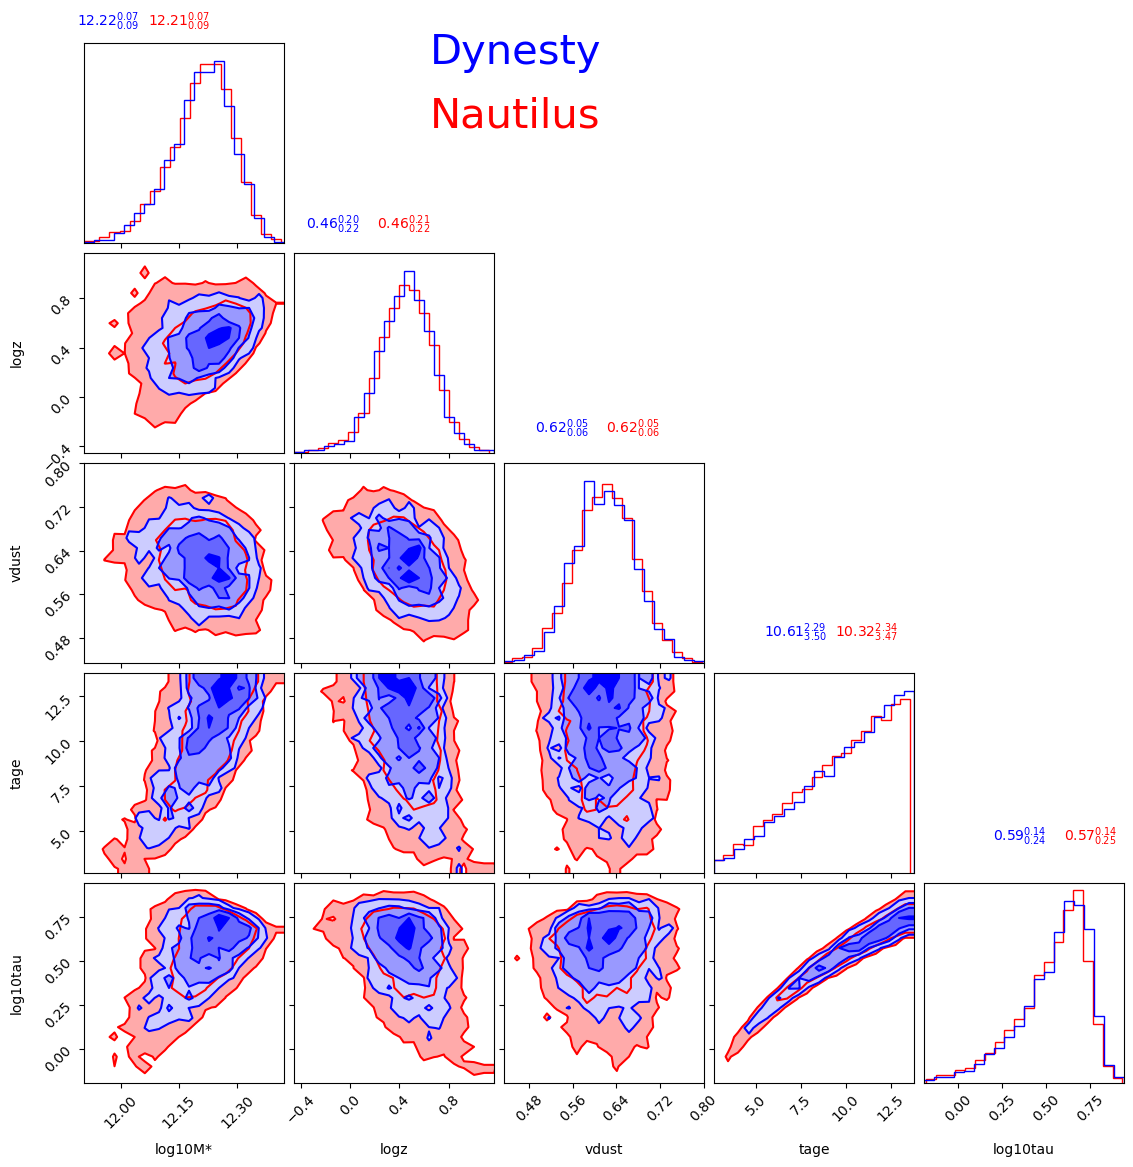

In [41]:

fig= corner.corner(points_v2, weights=np.exp(log_w_v2), bins=20, labels=prior_v2.keys,
              plot_datapoints=False, plot_density=False,
              fill_contours=True, levels=(0.68, 0.95),
              range=np.ones(ndim) * 0.999,color='red')
corner.corner(samples_dynesty_v2, weights=weights_dynesty_v2, bins=20, labels=prior_v2.keys,
              plot_datapoints=False, plot_density=False,
              fill_contours=True,
              range=np.ones(ndim) * 0.999,color='blue',alpha=0.5,fig=fig)
plt.text(-3,0.8,'Dynesty',color='blue',fontsize=30)
plt.text(-3,0.75,'Nautilus',color='red',fontsize=30)
for i in range(len(q_dynesty_v2[0])):
    num=len(q_dynesty_v2[0])
    plt.text(-num+i*1.3,0.83-0.8/num*i,'{:.2f}'.format(q_dynesty_v2[0][i])+r'$_{'+'{:.2f}'.format(q_dynesty_v2[1][i])+r'}^{'+'{:.2f}'.format(q_dynesty_v2[2][i])+r'}$',color='blue')
    plt.text(-num+i*1.3+0.4,0.83-0.8/num*i,'{:.2f}'.format(q_nautilus_v2[0][i])+r'$_{'+'{:.2f}'.format(q_nautilus_v2[1][i])+r'}^{'+'{:.2f}'.format(q_nautilus_v2[2][i])+r'}$',color='red')
plt.show()

<div class="green">

3. Use a Bayesian model comparison technique to decide which model your data prefer

In [42]:
# Nautilus 1
logz_nautilus=sampler.log_z
evidence_nautilus=np.exp(logz_nautilus)
print('Evidence Nautilus model 1: {:.2e}'.format(evidence_nautilus))

Evidence Nautilus model 1: 1.48e+60


In [43]:
# Nautilus 2
logz_nautilus_v2=n_sampler_v2.log_z
evidence_nautilus_v2=np.exp(logz_nautilus_v2)
print('Evidence Nautilus model 2: {:.2e}'.format(evidence_nautilus_v2))

Evidence Nautilus model 2: 5.66e+60


In [44]:
# Dynesty 1

logz_dynesty=sresults['logz']
evidence_dynesty=np.exp(logz_dynesty[-1])
print('Evidence Dynesty model 1: {:.2e}'.format(evidence_dynesty))

Evidence Dynesty model 1: 1.45e+60


In [45]:
# Dynesty 2

logz_dynesty_v2=results_v2['logz']
evidence_dynesty_v2=np.exp(logz_dynesty_v2[-1])
print('Evidence Dynesty model 2: {:.2e}'.format(evidence_dynesty_v2))

Evidence Dynesty model 2: 7.35e+60


In [46]:
# Ratio Nautilus 2/1

evidence_nautilus_v2/evidence_nautilus

3.8165729026257886

In [47]:
# Ratio Dynesty 2/1

evidence_dynesty_v2/evidence_dynesty

5.086913267765968

<font color='red'> 
    
### Fixed redshift model is better!
    
### For either implementation method, the evidence is greater for the model with fixed redshift compared to the free redshift model. Using Nautilus, the fixed redshift model is 3.8 times more likely than the free redshift model. Similarly, using Dynesty, the fixed redshift model is 5 times more likely than the free redshift model.

<div class="green">

# SECTION 3 - Comparing results



<div class="green">

1. How do the conclusions from your "Bayesian" model comparison compare to just looking at the change in the best-fit (reduced) chi-squared

In [54]:
def get_chi2(model_photo,deg):
    χ2=np.sum(((obs['maggies'] - model_photo) / obs['maggies_unc'])**2)
    red_χ2=χ2/deg
    return red_χ2

In [55]:
# Best-fit first model Dynesty
loglike=sresults['logl']
samples=sresults['samples']
best=np.where(loglike==np.max(loglike))
bestfit_dynesty=samples[best][0]
bestfit_dynesty[1]=10.**bestfit_dynesty[1]
bestfit_dynesty[5]=10.**bestfit_dynesty[5]
print(bestfit_dynesty)

[2.46998455e-01 1.80375809e+12 5.01907258e-01 6.15034074e-01
 1.27463212e+01 5.16302654e+00]


In [56]:
#print(model(bestfit_dynesty))
#print(obs['maggies'])
redχ2_d1=get_chi2(model(bestfit_dynesty),6)
print('Dynesty 1: Reduced χ2={:.2f}'.format(redχ2_d1))

Dynesty 1: Reduced χ2=0.53


In [57]:
# Best-fit second model Dynesty
loglike=results_v2['logl']
samples=results_v2['samples']
best=np.where(loglike==np.max(loglike))
bestfit_dynesty_v2=samples[best][0]
bestfit_dynesty_v2[0]=10**bestfit_dynesty_v2[0]
bestfit_dynesty_v2[4]=10**bestfit_dynesty_v2[4]

In [58]:
redχ2_d2=get_chi2(model_v2(bestfit_dynesty_v2),5)
print('Dynesty 2: Reduced χ2={:.2f}'.format(redχ2_d2))

Dynesty 2: Reduced χ2=0.65


In [59]:
# Best-fit first model Nautilus

best=np.where(log_l==np.max(log_l))
bestfit_nautilus=points[best][0]
bestfit_nautilus[1]=10**bestfit_nautilus[1]
bestfit_nautilus[5]=10**bestfit_nautilus[5]
print(bestfit_nautilus)

[2.61425822e-01 1.95637894e+12 3.64989881e-01 6.14182543e-01
 1.34452145e+01 5.69311907e+00]


In [60]:
redχ2_n1=get_chi2(model(bestfit_nautilus),6)
print('Nautilus 1: Reduced χ2={:.2f}'.format(redχ2_n1))

Nautilus 1: Reduced χ2=0.52


In [61]:
# Best-fit second model Nautilus

best=np.where(log_l_v2==np.max(log_l_v2))
bestfit_nautilus_v2=points_v2[best][0]
bestfit_nautilus_v2[0]=10**bestfit_nautilus_v2[0]
bestfit_nautilus_v2[4]=10**bestfit_nautilus_v2[4]

In [62]:
redχ2_n2=get_chi2(model_v2(bestfit_nautilus_v2),5)
print('Nautilus 2: Reduced χ2={:.2f}'.format(redχ2_n2))

Nautilus 2: Reduced χ2=0.61


<font color='red'> 

### For either implementation method, the reduced $\chi^2$ for either model is less than 1, which means that we are overfitting. The reduced $\chi^2$ for the fixed redshift model is closer to 1 than for the free redshift model, which says that the fixed redshift model is better than the free redshift model. This is consistent with the result from the evidence which says that the fixed redshift model is preferable.

<div class="green">

2. How do your experiences of inferring galaxy properties from MCMC compare to your inference using Machine Learning (Assignment 2 - Section 3)

* Which one was more accurate?
* What are their limitations?
* What unique infomation did the different approaches provide?

In [63]:
### Space to work
# Placeholder
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import sklearn

In [64]:
new_df=df.copy(deep=True)
new_df_out=df_out.copy(deep=True)
for i in range(8,len(df.T)):
    col_name=df.columns[i]
    cond=(new_df[col_name]<=9.9)&(new_df[col_name]!=0)
    new_df=new_df[cond]
    new_df_out=new_df_out[cond]
#cond=(new_df['redshift']>=0.15)&(new_df['redshift']<=0.4)
#new_df=new_df[cond]
#new_df_out=new_df_out[cond]

In [65]:
diff=np.sqrt((new_df['ra']-210.259583)**2+(new_df['dec']-2.880000)**2)
np.where(diff==np.min(diff))

(array([23615]),)

In [66]:
new_df.iloc[23613]

id                          289667
ra                      209.576634
dec                       2.745061
redshift                  0.089959
PLATE                          531
MJD                          52028
FIBERID                        469
designation    J135818.40+024442.0
flux0_u                   0.000085
flux0_u_e                 0.000003
flux0_g                   0.000267
flux0_g_e                 0.000002
flux0_r                   0.000516
flux0_r_e                 0.000003
flux0_i                   0.000783
flux0_i_e                 0.000004
flux0_z                   0.001043
flux0_z_e                 0.000012
flux0_w1                  0.001122
flux0_w1_e                0.000027
flux0_w2                   0.00083
flux0_w2_e                0.000024
flux0_w3                   0.00569
flux0_w3_e                0.000194
flux0_w4                  0.006047
flux0_w4_e                0.000919
flux_u                    0.000094
flux_u_e                  0.000006
flux_g              

In [67]:
size=len(new_df)
#print(size)
#choice=np.random.choice(size-1,10**4,replace=False)
choice=np.load('assignment3_choice.npy')
our_sample=new_df.iloc[choice]
out_sample=new_df_out.iloc[choice]
#print(our_sample['id'])
if(any(our_sample['id']==289679)or any(our_sample['id']==289667)):
    print('PROBLEM')
#np.save('assignment3_choice_3',choice)

In [68]:
input0=np.array([our_sample['flux_u'],our_sample['flux_g'],our_sample['flux_r'],our_sample['flux_i'],our_sample['flux_z'],our_sample['flux_w1'],our_sample['flux_w2'],our_sample['flux_w3'],our_sample['flux_w4']])
output0=np.array([our_sample['redshift'],out_sample['lmass50_all']])

In [69]:
cond=out_sample['flag_chi2']==1
input0=(input0.T[cond]).T
output0=(output0.T[cond]).T

In [70]:
id=[23615]
test_X=np.array([new_df.iloc[id]['flux_u'],new_df.iloc[id]['flux_g'],new_df.iloc[id]['flux_r'],new_df.iloc[id]['flux_i'],new_df.iloc[id]['flux_z'],new_df.iloc[id]['flux_w1'],new_df.iloc[id]['flux_w2'],new_df.iloc[id]['flux_w3'],new_df.iloc[id]['flux_w4']])
test_Y=np.array([new_df.iloc[id]['redshift'],new_df_out.iloc[id]['lmass50_all']])

In [71]:
new_input=np.concatenate((input0.T,test_X.T)).T
new_output=np.concatenate((output0.T,test_Y.T)).T

In [72]:
scaler_input=sklearn.preprocessing.RobustScaler()
scaler_input.fit(new_input.T)
norm_input=scaler_input.transform(new_input.T)
scaler_output=sklearn.preprocessing.RobustScaler()
scaler_output.fit(new_output.T)
norm_output=scaler_output.transform(new_output.T)
norm_output.shape

(9824, 2)

In [73]:
remove=len(id)
print(remove)
regr = MLPRegressor(random_state=69, max_iter=1000,hidden_layer_sizes=(100,100,100,100)).fit(norm_input[:-remove,:], norm_output[:-remove,:])

1


In [74]:
test_in=np.array(norm_input[-remove:])
print(test_in.shape)
prediction=regr.predict(test_in)

(1, 9)


In [75]:
out_predict=scaler_output.inverse_transform(prediction)
test_out=np.array(norm_output[-remove:])
true_out=scaler_output.inverse_transform(test_out)

In [76]:
out_predict[0],true_out[0]

(array([ 0.11964507, 11.1802635 ], dtype=float32),
 array([ 0.25195834, 11.73999977]))

In [77]:
d_tau,d_tau_m,d_tau_p=10**q_dynesty[0][-1],10**q_dynesty[0][-1]*np.log(10)*q_dynesty[1][-1],10**q_dynesty[0][-1]*np.log(10)*q_dynesty[2][-1]
n_tau,n_tau_m,n_tau_p=10**q_nautilus[0][-1],10**q_nautilus[0][-1]*np.log(10)*q_nautilus[1][-1],10**q_nautilus[0][-1]*np.log(10)*q_nautilus[2][-1]
print(d_tau,d_tau_m,d_tau_p)
print(n_tau,n_tau_m,n_tau_p)

3.857483227408224 2.2475376236647806 1.3673525588418427
3.780764211678948 2.1576506363431927 1.2875660962128224


<font color='red'> 

Chang et al. (2015) values: z=0.25195834 and Log$_{10}$ M$_*$ = 11.73999977

Nautilus values: z=0.26$^{+0.04}_{-0.04}$ and Log$_{10}$ M$_*$ = 12.22$^{+0.12]_{-0.12]$

Dynesty values: z=0.26$^{+0.04}_{-0.04}$ and Log$_{10}$ M$_*$ = 12.22$^{+0.12]_{-0.12]$

Assignment 2 values: z=0.11964507 and Log$_{10}$ M$_*$ = 11.1802635

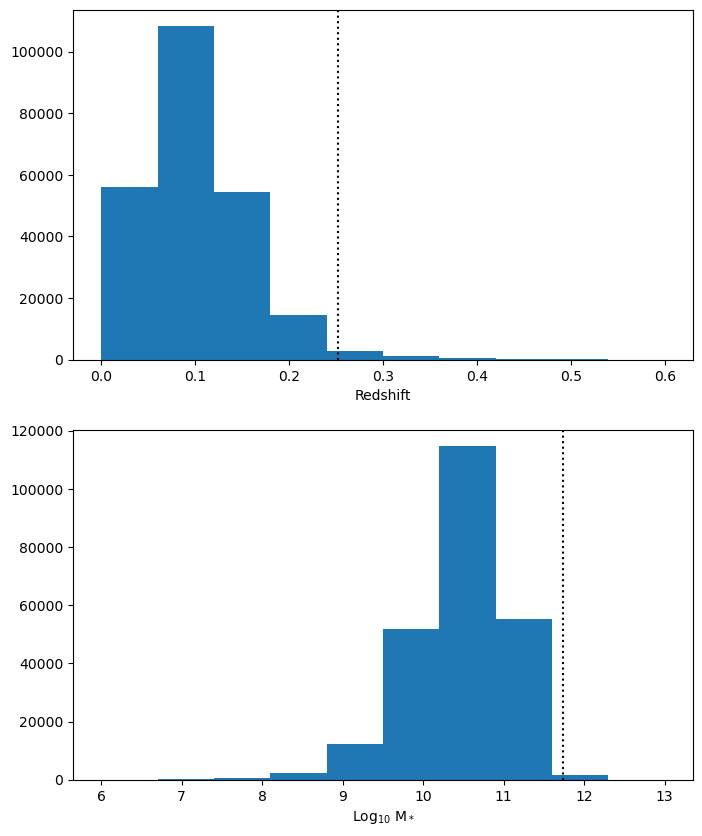

In [78]:
titles=['z',r'Log$_{10}$ M$_*$']
fig, ((ax1),(ax2)) = plt.subplots(2,1,figsize=((8,10)))
ax1.hist(new_df['redshift'],range=[0,0.6])
ax1.set_xlabel('Redshift')
ax1.axvline(test_Y.T[0][0],linestyle=':',color='black')
ax2.hist(new_df_out['lmass50_all'],range=[6,13])
ax2.set_xlabel(r'Log$_{10}$ M$_*$')
ax2.axvline(test_Y.T[0][1],linestyle=':',color='black')

<font color='red'> 

### Accuracy:

The redshift and stellar mass predicted for our object using assignment 2 are not accurate. As shown in the above figures, our chosen object has large z and M$_*$ compared to the Chang et al. (2015) sample which can bias our estimates since the model is being trained with galaxies with smaller z and M$_*$. It would be preferable to train the model with galaxies which are more similar to the object studied.

Since I have worked on this object before, I know that the "true" (most accepted) values of z and Log$_{10}$ M$_*$ are 0.2514 and 11.76. These are very close to the Chang et al. values. My assignment 3 value for the redshift is much more accurate than the redshift from assignment 2. The redshift from assignment 2 is very far from the "true" value, while the value from assignment 3 agrees with the "truth" within less than 1$\sigma$. The M$_*$ estimates from both methods are not very accurate. The stellar mass fitted by Dynesty and Nautilus is almost 4$\sigma$ away from the "truth".

### Limitations:

ML:

- As previously discussed, the training set is very important for this method. The model should be trained with objects with similar properties as the ones we are trying to estimate. Otherwise, this will bias the estimates and give worst results.

- The method from assignment 2 does not give us uncertainties on our estimates.

- We cannot use priors, or establish ranges of values allowed for the estimated quantities.

MCMC:

- Takes longer to run for many objects than ML. About that, Nautilus is significantly faster than Dynesty.
  
- MCMC relies on the model being used. You have to choose a model and your results hinge on the model chosen. The ML method from assignment 2 does not require us to define a model so it can predict the galaxies' properties without the need for a model.


### Unique information:

ML: Does not require a model so can get estimates of the galaxy's properties even if the model is completely unknown.

MCMC: With Dynesty and Nautilus, using the evidence, we can test different models to see which models better describes the data. It is also a good way to know if our MCMC has converged. Also, MCMC gives us uncertainties on our parameters as well as posteriors and corner plots. We can learn about covariance between the different parameters.
